In [7]:
# Imports and Data Loading

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import zipfile
import io
import re

def load_data_from_zip(zip_filepath='FROG.zip'):
    data_frames = {}
    with zipfile.ZipFile(zip_filepath, 'r') as z:
        for filename in z.namelist():
            if filename.endswith('.csv') and not filename.startswith('__MACOSX'):
                ticker_name = filename.split('/')[-1].split('.')[0]
                with z.open(filename) as f:
                    df = pd.read_csv(io.TextIOWrapper(f, 'utf-8'), low_memory=False)
                    df.columns = df.columns.str.strip()
                    df['ticker'] = ticker_name
                    data_frames[ticker_name] = df
    return data_frames
all_data = load_data_from_zip()

In [10]:
# Core Impact Calculation and Data Transformation

def calculate_temporary_impact(order_book_df, order_size_x):
    
    # Isolating the ask side of the order book and sort by price
    ask_book = order_book_df[order_book_df['type'] == 'ask'].sort_values('price').copy()
    
    # Checking if there is enough total volume to fill the order
    if ask_book['amount'].sum() < order_size_x:
        return np.nan

    shares_to_buy = order_size_x
    total_cost = 0
    shares_bought = 0

    # Iterating through liquidity levels until the order is filled
    for _, row in ask_book.iterrows():
        price = row['price']
        available_amount = row['amount']
        
        trade_amount = min(shares_to_buy, available_amount)
        total_cost += trade_amount * price
        shares_bought += trade_amount
        shares_to_buy -= trade_amount
        
        if shares_to_buy <= 0:
            break
            
    return total_cost / shares_bought

def get_empirical_impact_data(wide_df):
    
    impact_data = []
    
    # Finding all relevant price and size columns using flexible regex
    all_cols = wide_df.columns
    ask_price_cols = sorted([c for c in all_cols if re.match(r'ask_(p|pr|price|px)', c, re.IGNORECASE)])
    ask_size_cols = sorted([c for c in all_cols if re.match(r'ask_(c|ct|count|s|sz|size|v|vol)', c, re.IGNORECASE)])
    bid_price_cols = sorted([c for c in all_cols if re.match(r'bid_(p|pr|price|px)', c, re.IGNORECASE)])
    bid_size_cols = sorted([c for c in all_cols if re.match(r'bid_(c|ct|count|s|sz|size|v|vol)', c, re.IGNORECASE)])

    # Iterating over each row (time step) in the raw data
    for time_idx, row_data in wide_df.iterrows():
        order_book_levels = []
        
        # Parsing all ask levels from the wide format into a list of dicts
        for price_col, size_col in zip(ask_price_cols, ask_size_cols):
            if pd.notna(row_data[price_col]) and pd.notna(row_data[size_col]):
                try:
                    order_book_levels.append({'price': float(row_data[price_col]), 'amount': float(row_data[size_col]), 'type': 'ask'})
                except (ValueError, TypeError):
                    continue

        # Parsing all bid levels
        for price_col, size_col in zip(bid_price_cols, bid_size_cols):
            if pd.notna(row_data[price_col]) and pd.notna(row_data[size_col]):
                try:
                    order_book_levels.append({'price': float(row_data[price_col]), 'amount': float(row_data[size_col]), 'type': 'bid'})
                except (ValueError, TypeError):
                    continue

        if not order_book_levels:
            continue

        # Converting the parsed data into a clean, long-format DataFrame for this time step
        long_format_df = pd.DataFrame(order_book_levels)
        bid_group = long_format_df[long_format_df['type'] == 'bid']
        ask_group = long_format_df[long_format_df['type'] == 'ask']

        # Calculating slippage for various trade sizes
        if not bid_group.empty and not ask_group.empty:
            mid_price = (bid_group['price'].max() + ask_group['price'].min()) / 2
            total_ask_volume = ask_group['amount'].sum()
            if total_ask_volume > 0:
                # Simulating trades for a range of sizes (up to 20% of available volume)
                order_sizes = np.linspace(10, int(total_ask_volume * 0.20), 20)
                for x in order_sizes:
                    if x > 0:
                        avg_exec_price = calculate_temporary_impact(long_format_df, x)
                        if not np.isnan(avg_exec_price):
                            slippage = avg_exec_price - mid_price
                            slippage_bps = (slippage / mid_price) * 10000
                            impact_data.append({'time': time_idx, 'order_size': x, 'slippage_bps': slippage_bps})
                    
    return pd.DataFrame(impact_data)

In [11]:
# Market Impact Modeling and Optimal Execution Strategy

def fit_impact_model(empirical_data):
    
    model_params = []
    # Grouping the data by time step to fit a separate model for each
    for time, group in empirical_data.groupby('time'):
        if len(group) < 2:
            continue
            
        # Variables for linear regression: y = beta * z, where z = sqrt(x)
        y = group['slippage_bps'].values
        z = np.sqrt(group['order_size'].values).reshape(-1, 1)
        
        model = LinearRegression(fit_intercept=False)
        model.fit(z, y)
        beta = model.coef_[0]
        
        # Only include results where the beta is positive, as negative impact is not physical
        if beta > 0:
            r_squared = model.score(z, y)
            model_params.append({'time': time, 'beta': beta, 'r_squared': r_squared})
            
    return pd.DataFrame(model_params)

def calculate_optimal_schedule(total_shares_S, beta_df):

    # The optimal number of shares to trade is inversely proportional to beta^2
    betas = beta_df['beta'].values
    sum_inv_beta_sq = np.sum(1 / (betas**2))
    
    # Applying the closed-form solution derived from the Lagrangian
    optimal_shares = (1 / (betas**2)) * (total_shares_S / sum_inv_beta_sq)
    
    schedule = pd.DataFrame({
        'time': beta_df['time'],
        'beta': betas,
        'shares_to_buy': optimal_shares
    })
    return schedule

--- Starting Analysis for Ticker: FROG_2025-05-02 00:00:00+00:00 ---
Step 1: Calculating empirical impact...
Done.
Step 2: Fitting square-root impact model...
Done.
Step 3: Calculating optimal schedule to buy 100000 shares...
Done.

--- Generating Visualizations ---


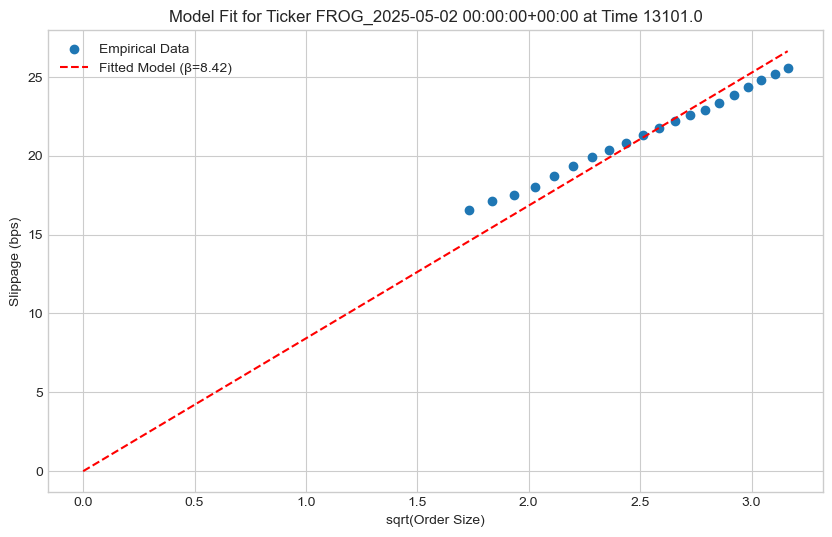

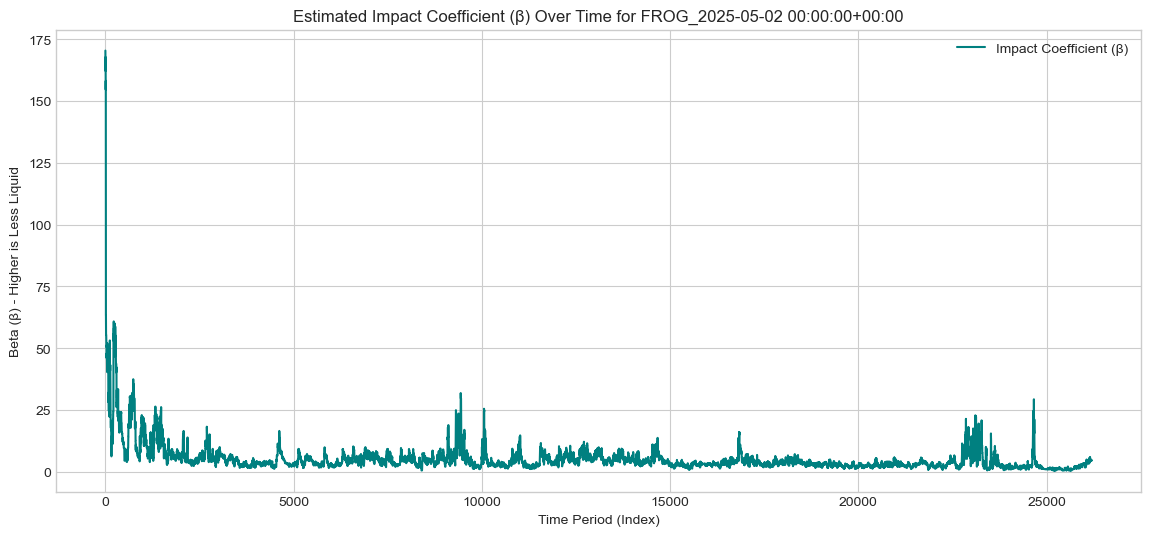

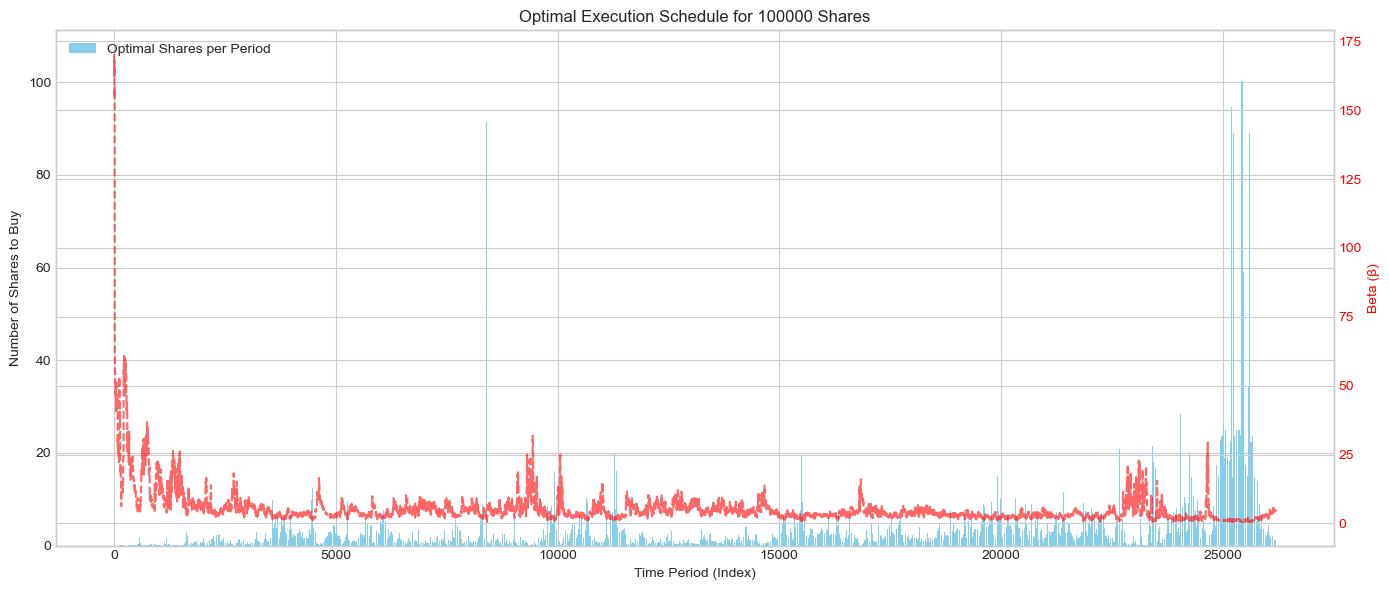


--- Analysis Complete ---
Total shares planned in schedule: 100000.00


In [12]:
# Main Execution and Visualization

TICKER_TO_ANALYZE = list(all_data.keys())[0] 
TOTAL_SHARES_TO_BUY = 100000

print(f"--- Starting Analysis for Ticker: {TICKER_TO_ANALYZE} ---")
ticker_df = all_data[TICKER_TO_ANALYZE]

# Processing raw data to calculate empirical slippage
print("Step 1: Calculating empirical impact...")
empirical_impact_df = get_empirical_impact_data(ticker_df)
print("Done.")

# Fitting the impact model to the empirical data
print("Step 2: Fitting square-root impact model...")
beta_df = fit_impact_model(empirical_impact_df)
print("Done.")

# Calculating the optimal execution schedule
print(f"Step 3: Calculating optimal schedule to buy {TOTAL_SHARES_TO_BUY} shares...")
optimal_schedule_df = calculate_optimal_schedule(TOTAL_SHARES_TO_BUY, beta_df)
print("Done.")

# Generating Visualizations ---
print("\n--- Generating Visualizations ---")
plt.style.use('seaborn-v0_8-whitegrid')

# Plot 1: Showing the quality of the model fit for a sample time period
fig1, ax1 = plt.subplots(figsize=(10, 6))
sample_time = beta_df.iloc[len(beta_df) // 2]['time']
sample_data = empirical_impact_df[empirical_impact_df['time'] == sample_time]
sample_beta = beta_df[beta_df['time'] == sample_time]['beta'].iloc[0]
ax1.scatter(np.sqrt(sample_data['order_size']), sample_data['slippage_bps'], label='Empirical Data')
x_fit = np.linspace(0, np.sqrt(sample_data['order_size']).max(), 100)
y_fit = sample_beta * x_fit
ax1.plot(x_fit, y_fit, color='red', linestyle='--', label=f'Fitted Model (β={sample_beta:.2f})')
ax1.set_title(f'Model Fit for Ticker {TICKER_TO_ANALYZE} at Time {sample_time}')
ax1.set_xlabel('sqrt(Order Size)')
ax1.set_ylabel('Slippage (bps)')
ax1.legend()
plt.show()

# Plot 2: Showing how the market impact parameter (liquidity) changes over the day
fig2, ax2 = plt.subplots(figsize=(14, 6))
ax2.plot(beta_df['time'], beta_df['beta'], label='Impact Coefficient (β)', color='teal')
ax2.set_title(f'Estimated Impact Coefficient (β) Over Time for {TICKER_TO_ANALYZE}')
ax2.set_xlabel('Time Period (Index)')
ax2.set_ylabel('Beta (β) - Higher is Less Liquid')
ax2.legend()
plt.show()

# Plot 3: Displaying the final optimal execution schedule
fig3, ax3 = plt.subplots(figsize=(14, 6))
ax3.bar(optimal_schedule_df['time'], optimal_schedule_df['shares_to_buy'], color='skyblue', label='Optimal Shares per Period')
ax3.set_title(f'Optimal Execution Schedule for {TOTAL_SHARES_TO_BUY} Shares')
ax3.set_xlabel('Time Period (Index)')
ax3.set_ylabel('Number of Shares to Buy')
ax3.legend()
# Overlay the beta coefficient to show the inverse relationship
ax4 = ax3.twinx()
ax4.plot(optimal_schedule_df['time'], optimal_schedule_df['beta'], color='red', linestyle='--', alpha=0.6, label='Impact Coeff. (β)')
ax4.set_ylabel('Beta (β)', color='red')
ax4.tick_params(axis='y', labelcolor='red')
fig3.tight_layout()
plt.show()

print("\n--- Analysis Complete ---")
print(f"Total shares planned in schedule: {optimal_schedule_df['shares_to_buy'].sum():.2f}")
